highly unbalanced data

492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('data/creditcard.csv')

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
data.shape

(284807, 31)

In [5]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [7]:
data['Class'].value_counts()
#1 이면 사기꾼

0    284315
1       492
Name: Class, dtype: int64

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Balancing Dataset

In [9]:
non_fraud=data[data['Class']==0]
fraud=data[data['Class']==1]

In [18]:
fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [11]:
non_fraud.shape , fraud.shape

((284315, 31), (492, 31))

In [12]:
non_fraud=non_fraud.sample(fraud.shape[0])
non_fraud.shape
#fraud.shape[0] = 492

(492, 31)

In [16]:
data=fraud.append(non_fraud,ignore_index=True)
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
1,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
2,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
3,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
4,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,74980.0,1.078431,0.053171,0.394354,1.301064,-0.155668,0.135208,-0.035141,0.150434,0.097928,...,-0.041865,0.007727,-0.089452,0.014640,0.609405,-0.330374,0.028962,0.008615,30.67,0
980,128179.0,0.012055,0.547624,-0.311687,0.837359,1.192483,-1.285071,1.013583,-0.229660,-0.248362,...,0.172450,0.525182,-0.102191,-0.047962,-0.217701,-0.539153,0.112115,0.101666,1.00,0
981,142590.0,-3.432350,-1.021969,1.419658,0.485116,-1.523392,1.259392,-0.748140,1.106319,1.549319,...,-0.017005,0.662136,-0.566208,0.737052,0.677107,0.021479,0.272719,-0.660764,152.57,0
982,78610.0,1.230666,0.141606,0.561500,1.234933,-0.415280,-0.357153,-0.112919,-0.013188,0.624758,...,-0.304883,-0.717076,0.011000,-0.003294,0.523814,-0.519985,0.036301,0.021962,1.00,0


In [17]:
data['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

In [49]:
x=data.drop(labels=['Class'],axis=1)
y=data['Class']

In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0,stratify=y)

In [51]:
x_train.shape, x_test.shape, y_train.shape

((787, 30), (197, 30), (787,))

In [52]:
scaler=StandardScaler()
x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [53]:
y_train

845    0
898    0
45     1
536    0
739    0
      ..
202    1
711    0
31     1
882    0
563    0
Name: Class, Length: 787, dtype: int64

In [54]:
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()
#y_train=np.array(y_train) 해도 됨

In [55]:
x_train=x_train.reshape(787,30,1)
x_test=x_test.reshape(197,30,1)

## build CNN

In [80]:
epochs=30
model=Sequential()
model.add(Conv1D(filters=32,kernel_size=2,activation='relu',input_shape=(30,1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64,kernel_size=2,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [81]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 29, 32)            96        
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 32)            128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 14, 32)            0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 64)            4160      
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 64)            256       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6, 64)            

In [82]:
model.compile(optimizer=Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

In [83]:
hist=model.fit(x_train,y_train,epochs=epochs,validation_data=(x_test,y_test),verbose=1)

Train on 787 samples, validate on 197 samples
Epoch 1/30
787/787 [==============================] - 2s 2ms/sample - loss: 1.0336 - accuracy: 0.5248 - val_loss: 0.6929 - val_accuracy: 0.5685
Epoch 2/30
787/787 [==============================] - 0s 177us/sample - loss: 0.9298 - accuracy: 0.5985 - val_loss: 0.6669 - val_accuracy: 0.6497
Epoch 3/30
787/787 [==============================] - 0s 180us/sample - loss: 0.7085 - accuracy: 0.6887 - val_loss: 0.6421 - val_accuracy: 0.7056
Epoch 4/30
787/787 [==============================] - 0s 176us/sample - loss: 0.7001 - accuracy: 0.7179 - val_loss: 0.6166 - val_accuracy: 0.7310
Epoch 5/30
787/787 [==============================] - 0s 181us/sample - loss: 0.6350 - accuracy: 0.7433 - val_loss: 0.5871 - val_accuracy: 0.7614
Epoch 6/30
787/787 [==============================] - 0s 173us/sample - loss: 0.5598 - accuracy: 0.7624 - val_loss: 0.5550 - val_accuracy: 0.8223
Epoch 7/30
787/787 [==============================] - 0s 173us/sample - loss: 0.

In [84]:
model.evaluate(x_test,y_test)

197/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.24978972118593715, 0.9137056]

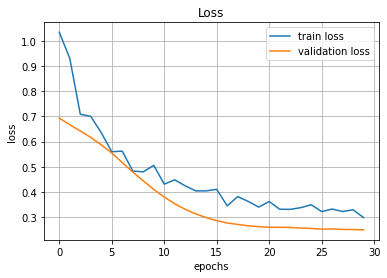

In [85]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')

plt.legend(loc='best')

plt.show()

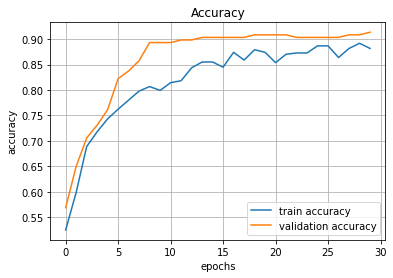

In [86]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')

plt.legend(loc='best')

plt.show()

In [87]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

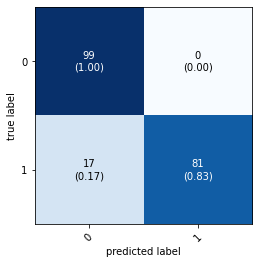

In [88]:
y_pred=model.predict_classes(x_test)
mat=confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mat,figsize=(4,4),class_names=['0','1'],show_normed=True)